In [62]:

import os
import time
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torchdyn

import ot as pot

from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

from random_processes import *
from models import *

from tqdm import tqdm
from tqdm.auto import trange
from rich.console import Console
from rich.progress import Progress, TextColumn, BarColumn, TimeElapsedColumn, TimeRemainingColumn

savedir = "savedir/MaskedCFM"
os.makedirs(savedir, exist_ok=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
# Seed initialization
def init_seed(use_fixed=True, fixed_seed=42):
    if use_fixed:
        seed = fixed_seed
    else:
        seed = int.from_bytes(os.urandom(64), "little")
    print(f"Using seed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed


init_seed(use_fixed=True, fixed_seed=42)

Using seed: 42


42

Conditional Sample Paths: $X_t \mid z = (x_0,x_1)$

1) Noisy Straight Paths: $ X_t = (1-t) x_0 + t x_1 + \sigma \epsilon $ where $\epsilon \sim \mathcal{N}(0, I)$.

2) Brownian Bridge Paths: $X_t = (1-t) x_0 + t x_1 + \sigma Z_t$ where $Z_t = W_t - tW_1$ is the Brownian bridge and $W_t$ is the standard Wiener process. Alternatively, $dZ_t = \frac{-Z_t}{1-t} dt + dW_t$ with $Z_0 = 0$ so that $dX_t = \frac{x_1-X_t}{1-t} dt + \sigma dW_t$ with $X_0 = x_0$.

In [65]:
def SampleConditionalNoisyStraightPath(x0, x1, t, sigma):
    """
    Draw a sample from the probability path xt = (1 - t) * x0 + t * x1 + sigma * epsilon 
    epsilon is standard normal random variable

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    xt : Tensor, shape (bs, *dim)
    """
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon


def SampleConditionalBrownianBridgePath(x0, x1, t, sigma):
    """
    Draw a sample from the probability path xt = (1 - t) * x0 + t * x1 + sigma * (Wt - t * W1)
    where Wt is a standard Brownian motion.

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    xt : Tensor, shape (bs, *dim)
    """
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    sigma_t = sigma * torch.sqrt(t * (1 - t))  #FIX THIS, should be Brownian bridge stddev
    epsilon = torch.randn_like(x0)             #FIX THIS, should be Brownian bridge noise
    return mu_t + sigma_t * epsilon

Conditional veocity field: $u(x,t \mid z)$ where $z= (x_0,x_1)$

1) Noisty Straight Paths: $u(x,t \mid z) = x_1 - x_0$ 
2) Brownian Bridge Paths: 
$$
u(x,t \mid z) = \frac{x_1 - x}{1-t} - \frac{\sigma^2}{2}\nabla \log p(x,t\mid z)
$$ 
where 
$$
p(x,t\mid z) = \mathcal{N}(x\mid m_t(z),\, \sigma^2 t(1-t) I),\quad m_t(z) = (1-t) x_0 + tx_1
$$
is the marginal distribution of the Brownian bridge between $x_0$ and $x_1$ at time $t\in [0,1]$. In closed form, this leads to 
$$
u(x,t \mid z) = (x_1-x_0) + \frac{1-2t}{2t(1-t)} (x - m_t(z)).
$$ 


In [66]:
# Implement the conditional velocity field for the Brownian Bridge

def ConditionalVelocityField(x0, x1):
    """
    Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch

    Returns
    -------
    ut : conditional vector field ut(x1|x0) = x1 - x0

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    return x1 - x0

Sampler from stochastically driven Lorenz attractor

In [67]:
lorenz_drift, lorenz_dif = make_lorenz_system(
    sigma=10.0, rho=28.0, beta=8/3, noise_scale=0.5
)

def lorenz_init_sampler(batch_size):
    return torch.empty(batch_size, 3).uniform_(-15, 15)

T = 50

lorenz_sampler = TorchSDEDiffusionSampler(
    lorenz_drift,
    lorenz_dif,
    t0=0.0,
    t1=1.0,
    steps=T-1,
    init_sampler=lorenz_init_sampler,
    method="euler",
)

Sampler from a Gaussian process with RBF kernel

In [68]:
dim = 2
T = 50
t_min = 0.0
t_max = 1.0

def mean_fn(t):
    amp = 1.0 + 0.5 * torch.sin(6 * 2 * torch.pi * t)
    angle = torch.pi * t
    return amp * torch.tensor([torch.cos(angle), torch.sin(angle)])
   
def zero_mean_fn(t):
    x = t * 0.0
    return torch.tensor([x, x])

A = torch.tensor([[1.0, 0.3], [0.3, 0.8]])
def cov_kernel(t, s):
    return rbf_kernel(t, s, sigma=1.0, tau=0.1, Cov=A)

times = torch.linspace(t_min, t_max, T)
gp_sampler = GaussianProcessSampler(mean_fn, cov_kernel, times, ldl_decomp=True, jitter=1e-4)
gp_mean, gp_cov = gp_sampler.get_stats()

In [69]:
var = 0.01

mean_prior = torch.zeros(dim*T).to(device)
mean_target = gp_mean.reshape(-1).to(device)


def sample_prior_data(batch_size):
    # Sample from N(0, I)
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(dim*T), var*torch.eye(dim*T))
    paths = m.sample((batch_size,)).float()  # shape (batch_size, T*dim)

    #print(f'{paths.shape}')
    
    return paths


def sample_target_data(batch_size):
    # Gaussian process paths
    paths = gp_sampler.sample(batch_size, flatten=True)  # shape (batch_size, T*dim)
    #print(f'{paths.shape}')
    # Lorenz system paths
    #traj, _, _ = lorenz_sampler.sample(num_paths=batch_size) # shape (batch_size, T, 3)
    #paths = traj[..., [0, 2]].reshape(batch_size, -1)  # take only x and z dimensions and flaten (bath_size, T*2)

    # Moons data
    #paths = sample_moons(batch_size)

    # 8 Gaussians data
    #paths = sample_8gaussians(batch_size)

    return paths


In [70]:
def compute_batch_loss(model_causal, model_full, batch_size):
    x0 = sample_prior_data(batch_size)
    x1 = sample_target_data(batch_size)
    t = torch.rand(x0.shape[0]).type_as(x0) #sample uniform times

    xt = SampleConditionalNoisyStraightPath(x0, x1, t, sigma=0.01)
    ut = ConditionalVelocityField(x0, x1)

    xt_in = torch.cat([xt, t[:, None]], dim=-1)    # (B, T*in_dim + 1)
    vt_causal = model_causal(xt_in)                # returns (B, T*out_dim)
    vt_full = model_full(xt_in) 

    loss_c = torch.mean((vt_causal - ut) ** 2)
    loss_f = torch.mean((vt_full - ut) ** 2)

    return loss_c, loss_f


def validate_forward(node, label, batch_val):
    x0 = sample_prior_data(batch_val).to(device)   # (batch_val, T*dim)

    #print(f'{x0.shape}')

    with torch.no_grad():
        traj = node.trajectory(x0, t_span=torch.linspace(0, 1, 2).to(device))
        #print(f'{traj.shape}')
    x1_pred = traj[-1]                             # final state (batch_val, T*dim)
    #print(f'{x1_pred.shape}')

    mean_pred = x1_pred.mean(dim=0)
    #print(f'{mean_pred.shape}')

    std_pred = x1_pred.std(dim=0)

    #print(f'{mean_target.shape}')

    mean_err = torch.sqrt(torch.norm(mean_pred - mean_target, p=2) ** 2 / T).item()
    sample_err = torch.sqrt(torch.mean(torch.norm(x1_pred - mean_target, dim=1) ** 2.  / T )).item()

    return {
        "mean_pred_target": mean_pred.detach().cpu(),
        "std_pred_target": std_pred.detach().cpu(),
        "mean_diff_target": mean_err,
        "mean_dev_target": sample_err,
        "label_target": label,
    }


def validate_backward(node, label, batch_val):
    x1 = sample_target_data(batch_val).to(device)          # (batch_val, T*dim)
    with torch.no_grad():
        traj = node.trajectory(x1, t_span=torch.linspace(1, 0, 2).to(device))
    x0_pred = traj[-1]                                     # inferred t=0 state

    mean_pred = x0_pred.mean(dim=0)
    std_pred = x0_pred.std(dim=0)

    mean_err = torch.sqrt(torch.norm(mean_pred - mean_prior, p=2) ** 2 / T).item()
    sample_err = torch.sqrt(torch.mean(torch.norm(x0_pred - mean_prior, dim=1) ** 2.  / T )).item()

    return {
        "mean_pred_prir": mean_pred.detach().cpu(),
        "std_pred_prior": std_pred.detach().cpu(),
        "mean_diff_prior": mean_err,
        "mean_dev_prior": sample_err,
        "label_prior": label,
    }

Independent coupling:
$$ \pi(dx_0, dx_1) = q_0(dx_0) q_1(dx_1)$$

In [ ]:
#%time

dim_w = 16 #hidden layers dimension per T
num_layers = 3
model_causal = MaskedBlockMLP(T=T, in_dim=dim, out_dim=dim, hidden_per_t=(dim_w,) * num_layers, causal=True, time_varying=True) 
model_full   = MaskedBlockMLP(T=T, in_dim=dim, out_dim=dim, hidden_per_t=(dim_w,) * num_layers, causal=False, time_varying=True) 

optimizer_causal = torch.optim.Adam(model_causal.parameters())
optimizer_full   = torch.optim.Adam(model_full.parameters())

batch_size = 2**10
batch_val = 2**10
num_steps = 10000
eval_every = 100

train_history = []
val_history = []
checkpoints = []  

console = Console(force_jupyter=True)  # ensures Rich draws in notebooks

if __name__ == "__main__":
    with Progress(
        TextColumn("{task.description}"),
        BarColumn(),
        TextColumn("Step {task.fields[step]:>4}/{task.total}"),
        TextColumn(
            "train: c {task.fields[loss_c]:>6.4f} | f {task.fields[loss_f]:>6.4f}\n"
            "F_c {task.fields[F_c_mean]:>6.4f}/{task.fields[F_c_sample]:>6.4f} | "
            "F_f {task.fields[F_f_mean]:>6.4f}/{task.fields[F_f_sample]:>6.4f}\n"
            "B_c {task.fields[B_c_mean]:>6.4f}/{task.fields[B_c_sample]:>6.4f} | "
            "B_f {task.fields[B_f_mean]:>6.4f}/{task.fields[B_f_sample]:>6.4f}"
        ),
        TimeElapsedColumn(),
        TimeRemainingColumn(),
        console=console,
        refresh_per_second=2
    ) as progress:
        task_id = progress.add_task(
            "Training",
            total=num_steps,
            step=0,
            loss_c=0.0,
            loss_f=0.0,
            F_c_mean=0.0,
            F_c_sample=0.0,
            F_f_mean=0.0,
            F_f_sample=0.0,
            B_c_mean=0.0,
            B_c_sample=0.0,
            B_f_mean=0.0,
            B_f_sample=0.0,
        )


        for step in range(num_steps):
            optimizer_causal.zero_grad()
            optimizer_full.zero_grad()

            loss_causal, loss_full = compute_batch_loss(model_causal, model_full, batch_size)

            loss_causal.backward()
            loss_full.backward()

            optimizer_causal.step()
            optimizer_full.step()

            train_history.append({
                "step": step + 1,
                "loss_causal": float(loss_causal.detach()),
                "loss_full": float(loss_full.detach()),
            })

            fields = {
                "step": step + 1,
                "loss_c": loss_causal.item(),
                "loss_f": loss_full.item(),
            }


            # Validation
            if (step + 1) % eval_every == 0:
                node_causal = NeuralODE(torch_wrapper(model_causal), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
                node_full = NeuralODE(torch_wrapper(model_full), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

                forward_stats_causal = validate_forward(node_causal, "causal", batch_val)
                forward_stats_full = validate_forward(node_full, "full", batch_val)

                backward_stats_causal = validate_backward(node_causal, "causal", batch_val)
                backward_stats_full = validate_backward(node_full, "full", batch_val)

                with torch.no_grad():
                    val_loss_c, val_loss_f = compute_batch_loss(model_causal, model_full, batch_size)
                
                val_history.append({
                    "step": step + 1,
                    "loss_causal": float(val_loss_c),
                    "loss_full": float(val_loss_f),
                    "forward_stats_causal": forward_stats_causal,
                    "forward_stats_full": forward_stats_full,
                    "backward_stats_causal": backward_stats_causal,
                    "backward_stats_full": backward_stats_full,
                })

                fields.update({
                    "F_c_mean": forward_stats_causal["mean_diff_target"],
                    "F_c_sample": forward_stats_causal["mean_dev_target"],
                    "F_f_mean": forward_stats_full["mean_diff_target"],
                    "F_f_sample": forward_stats_full["mean_dev_target"],
                    "B_c_mean": backward_stats_causal["mean_diff_prior"],
                    "B_c_sample": backward_stats_causal["mean_dev_prior"],
                    "B_f_mean": backward_stats_full["mean_diff_prior"],
                    "B_f_sample": backward_stats_full["mean_dev_prior"],
                })
            
            progress.update(task_id, advance=1, **fields)

Output()

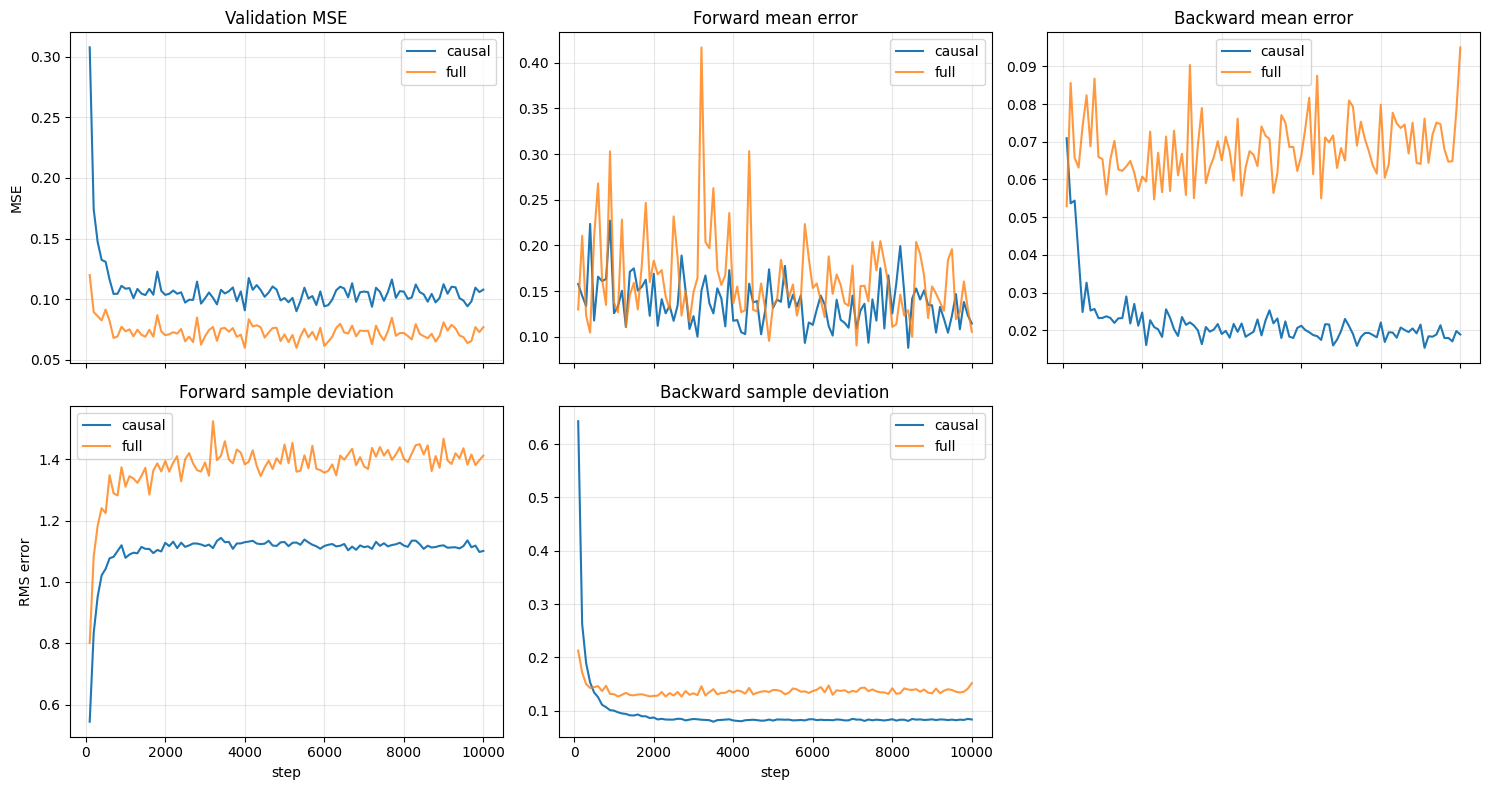

In [75]:
if not val_history:
    raise ValueError("val_history is empty – run validation before plotting.")

def flatten_val_entry(entry):
    return {
        "step": entry["step"],
        "loss_causal": entry["loss_causal"],
        "loss_full": entry["loss_full"],
        "forward_causal_mean_diff": entry["forward_stats_causal"]["mean_diff_target"],
        "forward_causal_mean_dev": entry["forward_stats_causal"]["mean_dev_target"],
        "forward_full_mean_diff": entry["forward_stats_full"]["mean_diff_target"],
        "forward_full_mean_dev": entry["forward_stats_full"]["mean_dev_target"],
        "backward_causal_mean_diff": entry["backward_stats_causal"]["mean_diff_prior"],
        "backward_causal_mean_dev": entry["backward_stats_causal"]["mean_dev_prior"],
        "backward_full_mean_diff": entry["backward_stats_full"]["mean_diff_prior"],
        "backward_full_mean_dev": entry["backward_stats_full"]["mean_dev_prior"],
    }

val_df = pd.DataFrame(flatten_val_entry(v) for v in val_history)

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
axes = axes.ravel()

axes[0].plot(val_df["step"], val_df["loss_causal"], label="causal")
axes[0].plot(val_df["step"], val_df["loss_full"], label="full", alpha=0.8)
axes[0].set_title("Validation MSE")
axes[0].set_ylabel("MSE")
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(val_df["step"], val_df["forward_causal_mean_diff"], label="causal")
axes[1].plot(val_df["step"], val_df["forward_full_mean_diff"], label="full", alpha=0.8)
axes[1].set_title("Forward mean error")
axes[1].grid(alpha=0.3)
axes[1].legend()

axes[2].plot(val_df["step"], val_df["backward_causal_mean_diff"], label="causal")
axes[2].plot(val_df["step"], val_df["backward_full_mean_diff"], label="full", alpha=0.8)
axes[2].set_title("Backward mean error")
axes[2].grid(alpha=0.3)
axes[2].legend()

axes[3].plot(val_df["step"], val_df["forward_causal_mean_dev"], label="causal")
axes[3].plot(val_df["step"], val_df["forward_full_mean_dev"], label="full", alpha=0.8)
axes[3].set_title("Forward sample deviation")
axes[3].set_xlabel("step")
axes[3].set_ylabel("RMS error")
axes[3].grid(alpha=0.3)
axes[3].legend()

axes[4].plot(val_df["step"], val_df["backward_causal_mean_dev"], label="causal")
axes[4].plot(val_df["step"], val_df["backward_full_mean_dev"], label="full", alpha=0.8)
axes[4].set_title("Backward sample deviation")
axes[4].set_xlabel("step")
axes[4].grid(alpha=0.3)
axes[4].legend()

axes[5].axis("off")

plt.tight_layout()
plt.show()

Optimal transport coupling:
$$ \pi_{\mathsf{OT}}(dx_0, dx_1) \triangleq \argmin_{\pi \in \mathscr{C}(\mathbb{Q}_0, \mathbb{Q}_1)} \frac{1}{2}\int \|x_0 - x_1\|^2 \pi(dx_0, dx_1) $$